In [9]:
import itertools
from functools import partial

import geopandas as gpd
import numpy as np
import pandas as pd
import vsketch
from fn.fn import new_savepath
from geodude.intersection import (
    assign_psuedoperiodic_order_to_adjacent_clusters,
    assign_random_order_to_adjacent_clusters,
    chunked_pairwise_partition_polygons, find_adjacency_clusters,
    find_contained_polys, find_intersecting_polys, find_parent_polygons,
    find_touching_polys, merge_disjoint_polys, pairwise_partition_polygons)
from geodude.line import bezier_func, dash_linestring
from geodude.ops import (buft_fill, form_affine_basis,
                         get_affine_transformation, make_like)
from geodude.parameter import Prm, prms
from geodude.subdivide import (bino_draw, flex_rule_recursive_split,
                               random_line_subdivide,
                               random_line_subdivide_gen,
                               split_along_longest_side_of_min_rectangle,
                               split_poly)
from geodude.utils import (Paper, flatten_geoms, merge_LineStrings,
                           merge_Polygons)
from matplotlib import pyplot as plt
from shapely import is_valid, unary_union
from shapely.affinity import affine_transform, translate
from shapely.geometry import (LineString, MultiLineString, MultiPoint,
                              MultiPolygon, Point, Polygon, box)
from shapely.ops import nearest_points

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# weave

In [2]:
# make page
paper_size = '11x14 inches'
border:float=30
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

In [15]:
drawbox.bounds

(30.0, 30.0, 249.39999999999998, 325.59999999999997)

In [44]:
circle_bottom = Point(250, 60).buffer(400, resolution=64)
circle_right = Point(200, 300).buffer(400, resolution=64)
circles = [circle_bottom, circle_right]

In [54]:
fills = []
for geom in circles:
    d_buffer = Prm(np.random.uniform(-10, -6))
    d_translate = Prm(lambda : d_buffer() * 0.1)
    deg = Prm(np.random.uniform(45, 90))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=100)
    
    for fill in polys.boundary.geoms:
        fill = fill.buffer(np.random.uniform(3, 5), resolution=64)
        fills.append(fill)
    

In [55]:
fdf = gpd.GeoDataFrame(geometry=fills).explode(index_parts=False).reset_index(drop=True)

In [56]:
disjoint = chunked_pairwise_partition_polygons(
    fdf, 
    chunk_size=10,
    min_area=1e-3,
    verbose=True,
    )

Iteration 1
Finding intersections in 110 polygons
4346 intersections remaining
Chunking polygons
Partitioning 11 chunks


11it [00:02,  3.72it/s]


Iteration 1 complete, 726 polygons remaining
Iteration 2
Finding intersections in 726 polygons
8378 intersections remaining
Chunking polygons
Partitioning 71 chunks


71it [00:06, 11.62it/s]


Iteration 2 complete, 1983 polygons remaining
Iteration 3
Finding intersections in 1983 polygons
13282 intersections remaining
Chunking polygons
Partitioning 171 chunks


171it [00:11, 15.28it/s]


Iteration 3 complete, 3736 polygons remaining
Iteration 4
Finding intersections in 3736 polygons
14964 intersections remaining
Chunking polygons
Partitioning 291 chunks


101it [00:10, 13.24it/s]/Users/alexandernaka/Library/Caches/pypoetry/virtualenvs/dashing-J-UKP8fp-py3.10/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
291it [00:16, 17.93it/s] 


Iteration 4 complete, 5478 polygons remaining
Iteration 5
Finding intersections in 5478 polygons
14572 intersections remaining
Chunking polygons
Partitioning 391 chunks


391it [00:19, 19.77it/s] 


Iteration 5 complete, 6848 polygons remaining
Iteration 6
Finding intersections in 6848 polygons
12090 intersections remaining
Chunking polygons
Partitioning 428 chunks


4it [00:00,  8.13it/s]/Users/alexandernaka/Library/Caches/pypoetry/virtualenvs/dashing-J-UKP8fp-py3.10/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: divide by zero encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/alexandernaka/Library/Caches/pypoetry/virtualenvs/dashing-J-UKP8fp-py3.10/lib/python3.10/site-packages/shapely/set_operations.py:235: RuntimeWarning: divide by zero encountered in symmetric_difference
  return lib.symmetric_difference(a, b, **kwargs)
428it [00:21, 19.56it/s] 


Iteration 6 complete, 7085 polygons remaining
Iteration 7
Finding intersections in 7085 polygons
8176 intersections remaining
Chunking polygons
Partitioning 368 chunks


368it [00:17, 20.79it/s]


Iteration 7 complete, 5521 polygons remaining
Iteration 8
Finding intersections in 5521 polygons
4528 intersections remaining
Chunking polygons
Partitioning 242 chunks


242it [00:11, 21.69it/s]


Iteration 8 complete, 3345 polygons remaining
Iteration 9
Finding intersections in 3345 polygons
2016 intersections remaining
Chunking polygons
Partitioning 123 chunks


123it [00:05, 22.99it/s]


Iteration 9 complete, 1533 polygons remaining
Iteration 10
Finding intersections in 1533 polygons
822 intersections remaining
Chunking polygons
Partitioning 53 chunks


53it [00:02, 24.74it/s]


Iteration 10 complete, 622 polygons remaining
Iteration 11
Finding intersections in 622 polygons
326 intersections remaining
Chunking polygons
Partitioning 20 chunks


20it [00:00, 25.70it/s]


Iteration 11 complete, 240 polygons remaining
Iteration 12
Finding intersections in 240 polygons
162 intersections remaining
Chunking polygons
Partitioning 11 chunks


11it [00:00, 17.92it/s]


Iteration 12 complete, 134 polygons remaining
Iteration 13
Finding intersections in 134 polygons
34 intersections remaining
Chunking polygons
Partitioning 3 chunks


3it [00:00, 23.78it/s]


Iteration 13 complete, 39 polygons remaining
Iteration 14
Finding intersections in 39 polygons
2 intersections remaining
Chunking polygons
Partitioning 1 chunks


1it [00:00, 78.57it/s]


Iteration 14 complete, 2 polygons remaining
Iteration 15
Finding intersections in 2 polygons
0 intersections remaining
Chunking polygons


In [57]:
disjoint = find_parent_polygons(disjoint=disjoint, original=fdf)
disjoint = assign_random_order_to_adjacent_clusters(disjoint)

In [89]:
ngdf = merge_disjoint_polys(disjoint)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

# clean up with closing + opening
buffer_value = 1e-3
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

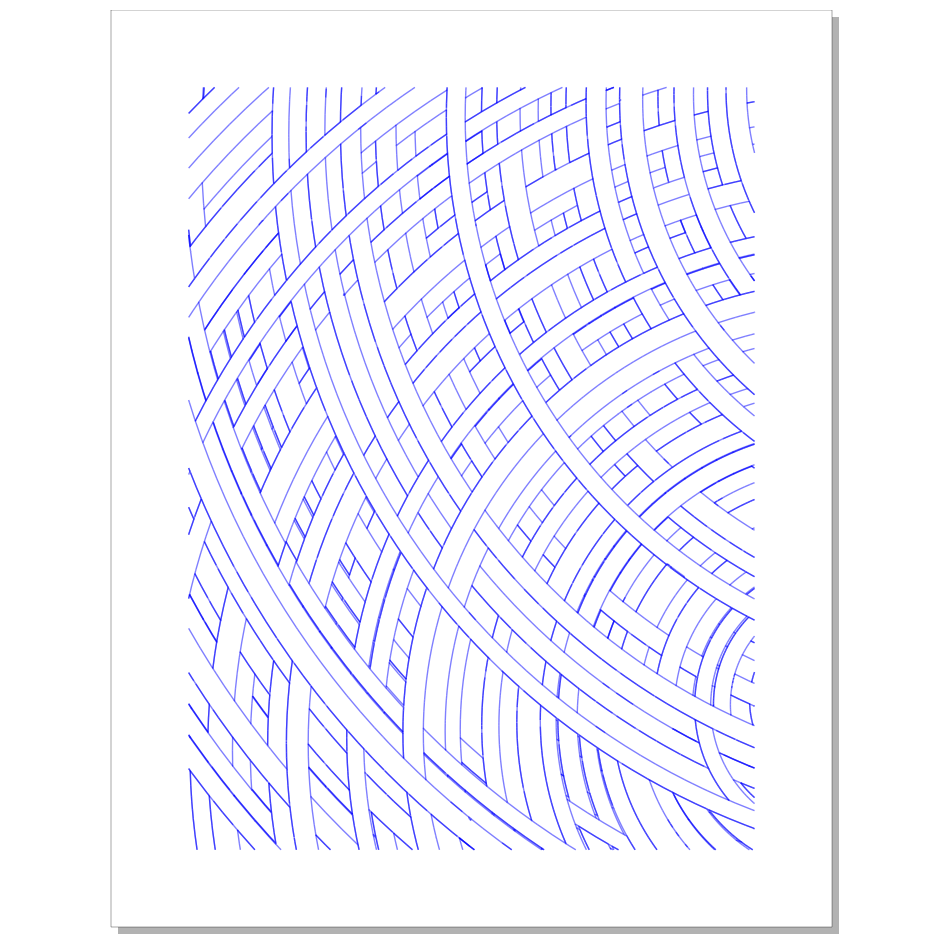

In [104]:
ngdf['area'] = ngdf.area
idx = (ngdf.area > 1e-9) & ~ngdf.is_empty
idx = idx & (ngdf.geom_type == 'Polygon')
# idx = idx & ngdf.is_valid
ngdf = ngdf[idx]
sampled_ngdf = ngdf.sample(frac=1, replace=False)
sampled_ngdf.geometry = sampled_ngdf.geometry.apply(translate, xoff=200)
lss = [p.boundary for p in sampled_ngdf.geometry if p.boundary is not None]
mls = merge_LineStrings(lss)


sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)

tmls = translate(mls).intersection(drawbox)

sk.geometry(tmls)
sk.display(fig_size=(12,12))

In [105]:
fills = []
# fdf.geometry = fdf.geometry.apply(translate, xoff=200)
for geom in fdf.geometry:
    d_buffer = Prm(np.random.uniform(-0.5, -0.2))
    d_translate = Prm(lambda : d_buffer() * np.random.uniform(0.4, 0.9))
    deg = Prm(np.random.uniform(230, 260))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=200)
    fills.append(polys.boundary.intersection(drawbox))
fill_gdf = gpd.GeoDataFrame(geometry=fills)

In [127]:
masked = []

for ii, row in fill_gdf.iterrows():
    fill = row.geometry
    mask = sampled_ngdf.query('parent == @ii').geometry.buffer(1e-6)
    _fill = fill.intersection(mask)
    masked.append(_fill)
    masked.append(mask.intersection(drawbox).boundary)
masked = pd.concat(masked)
masked = masked[~masked.is_empty]
fill_mls = merge_LineStrings(masked.to_list())

(50.0, 100.0)

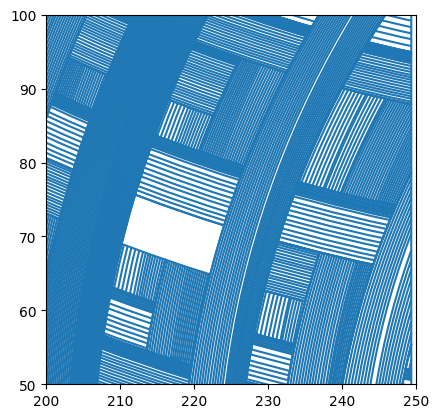

In [128]:
masked.plot()
plt.xlim(200,250)
plt.ylim(50,100)

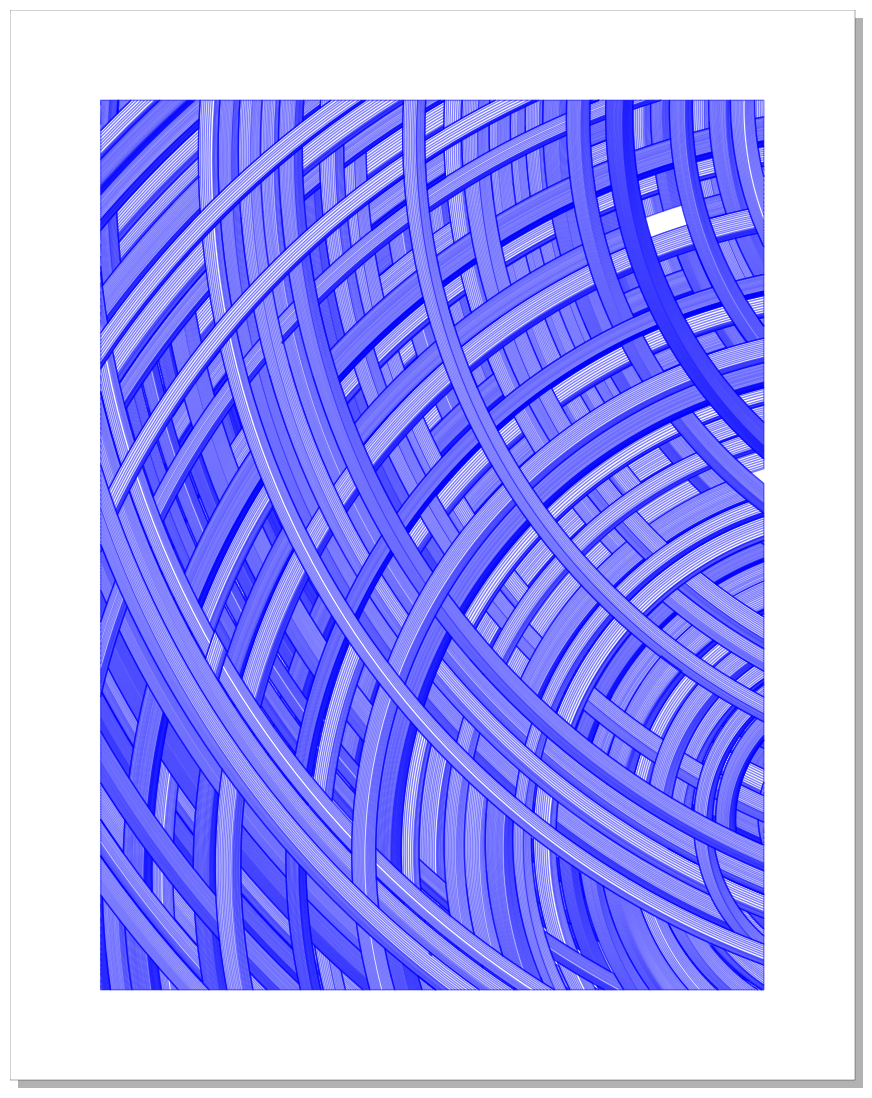

In [129]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(fill_mls)
sk.display(fig_size=(11, 14))

In [130]:
sk.vpype('linesort')

In [131]:
fp = new_savepath(postfix='circles_and_subdivides_filled')
sk.save(fp)

# less is mor

In [27]:
# make page
paper_size = '11x14 inches'
border:float=30
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

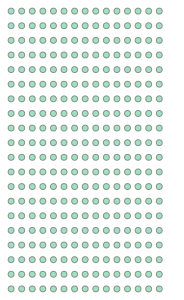

In [38]:
n_xs = 15
n_ys = 20
n_pts = n_xs * n_ys
xs = np.linspace(30, 190, n_xs)
ys = np.linspace(0, 300, n_ys)
pts = [Point(x, y) for x, y in itertools.product(xs, ys)]
radii = [np.interp(pt.y, [0, 300], [1, 30]) for pt in pts]
thicknesses = [np.interp(pt.y, [0, 300], [0.3, 2.2]) for pt in pts]

MultiPoint(pts)

In [39]:
circles = [p.buffer(r).boundary.buffer(thickness) for p,r, thickness in zip(pts, radii, thicknesses)]

In [59]:
mp = make_like(MultiPolygon(circles), drawbox)

In [65]:
fdf = gpd.GeoDataFrame(geometry=list(mp.geoms)).explode(index_parts=False).reset_index(drop=True)


In [66]:

mls = merge_LineStrings(fdf.geometry.boundary.values)

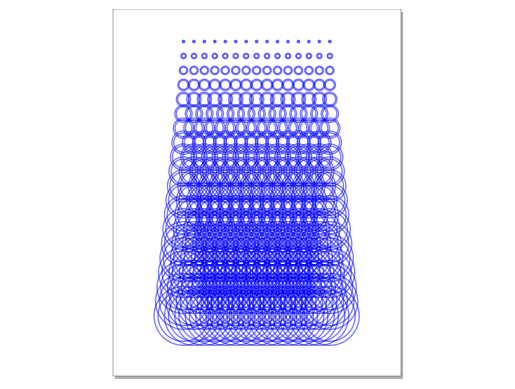

In [67]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)

sk.geometry(mls)
sk.display()


In [68]:

disjoint = chunked_pairwise_partition_polygons(
    fdf, 
    chunk_size=20,
    min_area=1e-3,
    verbose=True,
    )

Iteration 1
Finding intersections in 300 polygons
5780 intersections remaining
Chunking polygons
Partitioning 13 chunks


13it [00:08,  1.55it/s]


Iteration 1 complete, 2369 polygons remaining
Iteration 2
Finding intersections in 2369 polygons
11322 intersections remaining
Chunking polygons
Partitioning 59 chunks


59it [00:17,  3.41it/s]


Iteration 2 complete, 4552 polygons remaining
Iteration 3
Finding intersections in 4552 polygons
19514 intersections remaining
Chunking polygons
Partitioning 167 chunks


167it [00:32,  5.12it/s]


Iteration 3 complete, 8006 polygons remaining
Iteration 4
Finding intersections in 8006 polygons
19568 intersections remaining
Chunking polygons
Partitioning 270 chunks


270it [00:33,  7.96it/s]


Iteration 4 complete, 9339 polygons remaining
Iteration 5
Finding intersections in 9339 polygons
13932 intersections remaining
Chunking polygons
Partitioning 274 chunks


274it [00:29,  9.33it/s]


Iteration 5 complete, 7815 polygons remaining
Iteration 6
Finding intersections in 7815 polygons
6900 intersections remaining
Chunking polygons
Partitioning 173 chunks


173it [00:15, 11.01it/s]


Iteration 6 complete, 4390 polygons remaining
Iteration 7
Finding intersections in 4390 polygons
2996 intersections remaining
Chunking polygons
Partitioning 83 chunks


83it [00:07, 10.92it/s]


Iteration 7 complete, 2053 polygons remaining
Iteration 8
Finding intersections in 2053 polygons
1064 intersections remaining
Chunking polygons
Partitioning 33 chunks


33it [00:02, 12.86it/s]


Iteration 8 complete, 731 polygons remaining
Iteration 9
Finding intersections in 731 polygons
386 intersections remaining
Chunking polygons
Partitioning 11 chunks


11it [00:00, 11.21it/s]


Iteration 9 complete, 256 polygons remaining
Iteration 10
Finding intersections in 256 polygons
172 intersections remaining
Chunking polygons
Partitioning 6 chunks


6it [00:00, 10.85it/s]


Iteration 10 complete, 120 polygons remaining
Iteration 11
Finding intersections in 120 polygons
18 intersections remaining
Chunking polygons
Partitioning 1 chunks


1it [00:00, 17.41it/s]

Iteration 11 complete, 11 polygons remaining
Iteration 12
Finding intersections in 11 polygons
0 intersections remaining
Chunking polygons


In [69]:
disjoint = find_parent_polygons(disjoint=disjoint, original=fdf)
disjoint = assign_random_order_to_adjacent_clusters(disjoint)

In [95]:
ngdf = merge_disjoint_polys(disjoint)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

# clean up with closing + opening
buffer_value = 1e-3
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

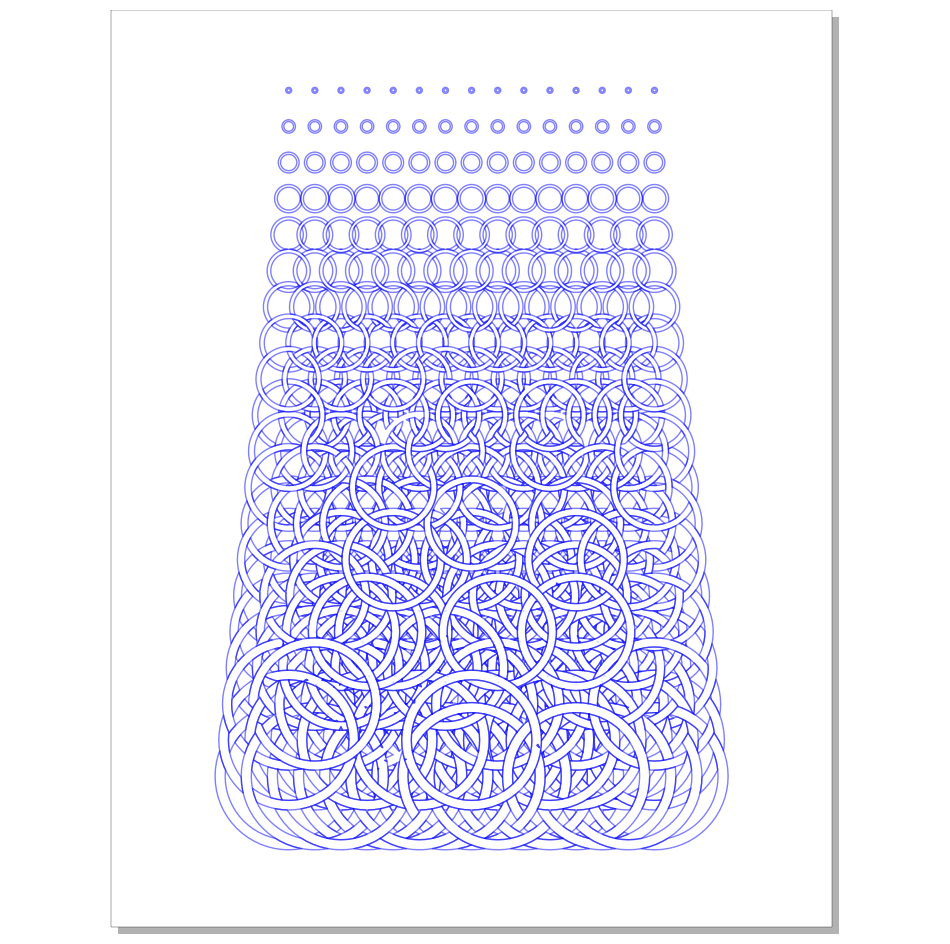

In [96]:
ngdf['area'] = ngdf.area
idx = (ngdf.area > 1e-9) & ~ngdf.is_empty
idx = idx & (ngdf.geom_type == 'Polygon')
# idx = idx & ngdf.is_valid
ngdf = ngdf[idx]
sampled_ngdf = ngdf.sample(frac=1, replace=False)
# sampled_ngdf.geometry = sampled_ngdf.geometry.apply(translate, xoff=200)
lss = [p.boundary for p in sampled_ngdf.geometry if p.boundary is not None]
mls = merge_LineStrings(lss)


sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)

# tmls = translate(mls).intersection(drawbox)

sk.geometry(mls)
sk.display(fig_size=(12,12))

In [97]:
fills = []
# fdf.geometry = fdf.geometry.apply(translate, xoff=200)
for geom in fdf.geometry:
    d_buffer = Prm(np.random.uniform(-0.5, -0.2))
    d_translate = Prm(lambda : d_buffer() * np.random.uniform(0.4, 0.9))
    deg = Prm(np.random.uniform(230, 260))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=200)
    fills.append(polys.boundary.intersection(drawbox))
fill_gdf = gpd.GeoDataFrame(geometry=fills)

In [98]:
masked = []

for ii, row in fill_gdf.iterrows():
    fill = row.geometry
    mask = sampled_ngdf.query('parent == @ii').geometry.buffer(1e-6)
    _fill = fill.intersection(mask)
    masked.append(_fill)
    masked.append(mask.intersection(drawbox).boundary)
masked = pd.concat(masked)
masked = masked[~masked.is_empty]
fill_mls = merge_LineStrings(masked.to_list())

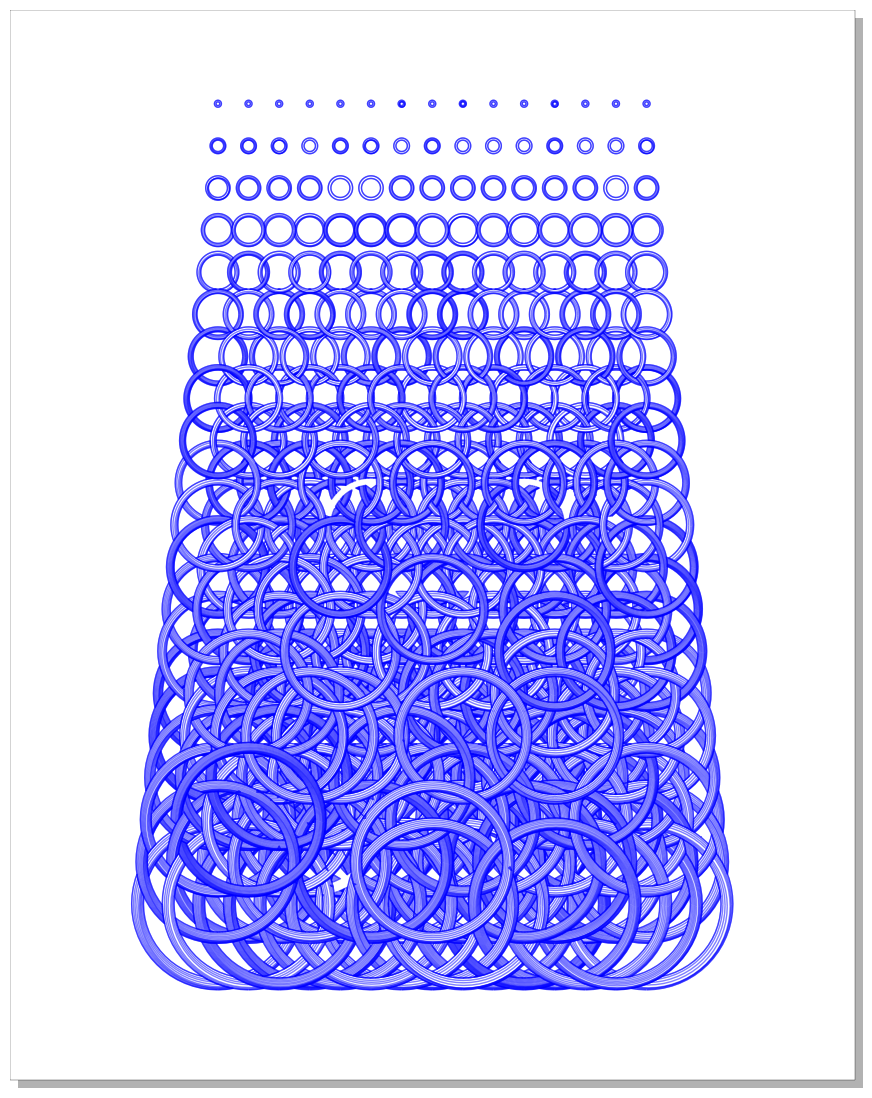

In [99]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(fill_mls)
sk.display(fig_size=(11, 14))

In [ ]:
sk.vpype('linesort')

In [ ]:
fp = new_savepath(postfix='circles_and_subdivides_filled')
sk.save(fp)